#Instructions

This document is a template to help you get started and will mirror the work that you will do in modules 2, 3, 4 and 5 with the Taxi Trip dataset problem.

You should save a copy of this in your Colab and change the name of the file to include your student number.

Within this document there are comments to help you along and some boilerplate code that you can adjust to get you started but the code will be very similar to that found in the practice document.

This document has the following sections and should be submitted with those in place:



*   Title
*   Introduction
*   Module 2: Get the data
*   Module 3: Basic statistics and visualisations
*   Module 4: Regression models
*   Module 5: Using the outcomes 


Enjoy and learn lots.

# Problem: Can we accurately predict the number of collisions for any given day of the week?

##Introduction

You work as a product owner for a car insurance company offering a daily insurance policy for car rentals.   

The company operates in New York and wants to price its insurance to reflect collision risk and associated costs. It wants you to explore a new feature for development that will make better predictions about this. We will use New York traffic collision data to make estimates about the number of collisions on a given day.  

For this you require weather data as there has been a link between weather and traffic collisions. The company is using data given to them by the emergency services.

Note: You will be given a file entitled collisions_and_weather_data.csv testdata2019.csv. Due to Covid-19, all data since early 2020 has been fairly useless with respect to patterns. The company can see that the data has recently returned to full pre-pandemic levels and you will be provided data from 1st of January 2013 to 31st of December 2018 and the test data will be from 2019.   

Remember, you will have to put these files in your Google Drive.

## Module 2: Get the data

This section contains boilerplate code. As long as you have uploaded your CSV files to your Google Drive, you can just run the cells as normal.

In [3]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import plotly as pl
import plotly.graph_objects as go
import plotly.express as px
import datetime as dt

In [ ]:
#set the size of our plots as they are a little small by default.
plt.rcParams["figure.figsize"] = (20,5)

In [49]:
# Custom functions and constants
custom_plasma_scale = [
    [0, px.colors.sequential.Plasma[0]],  # Start of the Plasma scale
    # Map points in between as needed; this example directly jumps to clamping
    [0.8, px.colors.sequential.Plasma[-2]],  # Roughly the 80% mark in the Plasma palette
    [1, px.colors.sequential.Plasma[-2]]  # Clamp the color scale to the color at 80%
]
ZICD = 'ZICD_grouped_by_week_day'
ZICD_YEAR_DAY = 'ZICD_grouped_by_year_day'

def find_first_monday_of_september(year):
    #"""Find the first Monday of September for the given year."""
    # September 1st of the given year
    date = dt.datetime(year, 9, 1)
    # Calculate how many days to add to get to the first Monday (1=Monday, 7=Sunday)
    days_to_add = (7 - date.weekday()) % 7
    first_monday = date + dt.timedelta(days=days_to_add)
    return first_monday


def adjust_calendar_to_labor_day(year, day_of_year):
        # Find the first Monday of September (Labor Day)
    labor_day = find_first_monday_of_september(year)
    labor_day_previous_day = labor_day - dt.timedelta(days=2)  # Two days before Labor day so Sat is now day 1.
    labor_day_previous_day_of_year = labor_day_previous_day.timetuple().tm_yday


    # Before the day after Labor Day, wrap around to the end of the cycle
    days_in_year = 366 if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0) else 365
    return (day_of_year - labor_day_previous_day_of_year) % days_in_year

def convert_date_to_zero_indexed_cycle_day_grouped_by_day_of_week(year,month,day, day_num):
    flip = False #day_num < 2
    temp_day_num = 1 -day_num if flip else day_num 
    date = dt.datetime(year, month, day)
    day_of_year = date.timetuple().tm_yday

    adjusted_day_of_year = day_of_year # adjust_calendar_to_labor_day(year, day_of_year) REMOVED LABOR DAY ADJUSTMENT

    day_of_total_cycle = (adjusted_day_of_year) + (temp_day_num*366)
    return day_of_total_cycle - (1-temp_day_num) if flip else day_of_total_cycle

def convert_date_to_zero_indexed_cycle_day_grouped_by_day_of_year(year, month, day, day_num):
    flip = False #day_num < 2
    temp_day_num = 1 -day_num if flip else day_num 
    date = dt.datetime(year, month, day)
    day_of_year = date.timetuple().tm_yday

    adjusted_day_of_year = day_of_year # adjust_calendar_to_labor_day(year, day_of_year) REMOVED LABOR DAY ADJUSTMENT

    # Calculate day of total cycle with the adjusted day_of_year
    day_of_total_cycle = (adjusted_day_of_year + temp_day_num) + (6 * adjusted_day_of_year)

    return day_of_total_cycle - (1-temp_day_num) if flip else day_of_total_cycle

def show_correlation_matrix(df, title):
    corrMatrix = df.corr(numeric_only=True)
    fig = px.imshow(
        corrMatrix,
        width=1000,
        height=1000,
        title=title,
        color_continuous_scale='PiYG',
        zmin=-1,
        zmax=1
        )
    fig.update_yaxes(tickfont=dict(family='Century Gothic', size=14), range=[-1,1])
    fig.update_xaxes(tickfont=dict(family='Century Gothic', size=14))

    alt = "Hello"
    fig.show()


days_titles = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat' ]

In [ ]:
# Link with your google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [50]:
# get our collated taxi trip and weather data from google drive
df = pd.read_csv('D:\\Coding\\JupyterNotebookLBD\\scientificProject\\data\\LBD_New_York_collisions_and_weather_data (1).csv')
df.replace({9999.9: np.nan, 999.9: np.nan, 99.99: np.nan}, inplace=True)
df['day'] = (df['day'] + 1) % 7
df.loc[df['day'] < 2, 'day'] = 1 - df['day']  


df[ZICD] = df.apply(lambda row: convert_date_to_zero_indexed_cycle_day_grouped_by_day_of_week(row['year'], row['mo'], row['da'], row['day']), axis=1)
df[ZICD_YEAR_DAY] = df.apply(lambda row: convert_date_to_zero_indexed_cycle_day_grouped_by_day_of_year(row['year'], row['mo'], row['da'], row['day']), axis=1)

In [5]:
df.head()

,day,year,mo,da,collision_date,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,NUM_COLLISIONS
0,2,2013,1,1,01/01/2013,37.8,23.6,1011.9,10.0,6.1,8.9,19.0,39.9,33.1,0.0,999.9,0,381
1,3,2013,1,2,02/01/2013,27.1,10.5,1016.8,10.0,5.3,9.9,19.0,33.1,21.9,0.0,999.9,0,480
2,4,2013,1,3,03/01/2013,28.4,14.1,1020.6,10.0,3.7,8.0,15.0,32.0,24.1,0.0,999.9,0,549
3,5,2013,1,4,04/01/2013,33.4,18.6,1017.0,10.0,6.5,13.0,24.1,37.0,30.0,0.0,999.9,0,505
4,6,2013,1,5,05/01/2013,36.1,18.7,1020.6,10.0,6.6,12.0,21.0,42.1,32.0,0.0,999.9,0,389


## Module 3: Basic statistics and visualisations

In [7]:
df = df.sort_values(["year", "mo", "da"], ascending = (True, True, True)) # order the data by year, month, day in ascending order.
df.head() # check the data again by viewing the first 5 rows

,day,year,mo,da,collision_date,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,NUM_COLLISIONS
0,2,2013,1,1,01/01/2013,37.8,23.6,1011.9,10.0,6.1,8.9,19.0,39.9,33.1,0.0,999.9,0,381
1,3,2013,1,2,02/01/2013,27.1,10.5,1016.8,10.0,5.3,9.9,19.0,33.1,21.9,0.0,999.9,0,480
2,4,2013,1,3,03/01/2013,28.4,14.1,1020.6,10.0,3.7,8.0,15.0,32.0,24.1,0.0,999.9,0,549
3,5,2013,1,4,04/01/2013,33.4,18.6,1017.0,10.0,6.5,13.0,24.1,37.0,30.0,0.0,999.9,0,505
4,6,2013,1,5,05/01/2013,36.1,18.7,1020.6,10.0,6.6,12.0,21.0,42.1,32.0,0.0,999.9,0,389


In [ ]:
df.describe()

,day,year,mo,da,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,NUM_COLLISIONS
count,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000
mean,4.000000,2015.500228,6.523962,15.726609,55.721086,41.120310,1107.412871,23.426654,50.871976,55.427704,384.628617,65.226974,47.875947,0.141031,920.095710,0.079416,602.121862
std,2.000457,1.707859,3.449207,8.800821,17.506851,19.298085,895.814069,118.917338,209.762963,208.768664,473.640573,18.156330,17.152164,0.353569,270.092092,0.270448,102.452173
min,1.000000,2013.000000,1.000000,1.000000,6.900000,-16.100000,992.100000,1.700000,0.000000,2.900000,14.000000,17.600000,-0.900000,0.000000,1.200000,0.000000,10.000000
25%,2.000000,2014.000000,4.000000,8.000000,41.550000,26.400000,1012.700000,8.500000,3.100000,7.000000,18.100000,50.000000,35.100000,0.000000,999.900000,0.000000,533.000000
50%,4.000000,2016.000000,7.000000,16.000000,56.900000,42.600000,1017.000000,9.800000,4.400000,8.900000,24.100000,66.900000,48.000000,0.000000,999.900000,0.000000,604.000000
75%,6.000000,2017.000000,10.000000,23.000000,71.900000,57.500000,1022.000000,10.000000,5.900000,11.100000,999.900000,82.000000,64.000000,0.080000,999.900000,0.000000,670.000000
max,7.000000,2018.000000,12.000000,31.000000,89.100000,74.800000,9999.900000,999.900000,999.900000,999.900000,999.900000,98.100000,82.900000,4.530000,999.900000,1.000000,1161.000000


In [57]:
# corrMatrix = df.corr()
# sn.heatmap(corrMatrix, annot=True)
# plt.show()

show_correlation_matrix(df, "Collision Correlations")

num_trips_to_zicd = px.scatter(
    df,
    x=ZICD,
    y='NUM_COLLISIONS',
    color='day',
    color_continuous_scale=custom_plasma_scale,  # Use the custom Plasma scale
    title='NUM_COLLISIONS / '+ZICD
)

num_trips_to_zicd_year = px.scatter(
    df,
    x=ZICD_YEAR_DAY,
    y='NUM_COLLISIONS' ,
    color='day',
    color_continuous_scale=custom_plasma_scale,  # Use the custom Plasma scale
    title='NUM_COLLISIONS / '+ZICD_YEAR_DAY
)



num_trips_to_zicd.show()

num_trips_to_zicd_year.show()


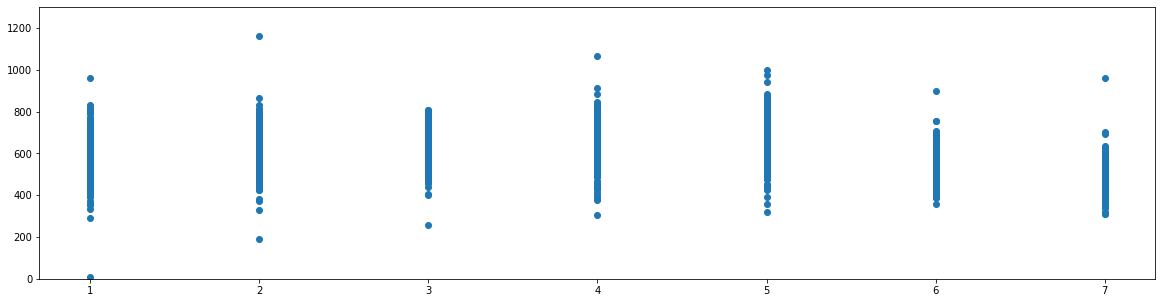

In [ ]:
plt.ylim(0, 1300)
plt.scatter(df.day, df.NUM_COLLISIONS) 
plt.show()

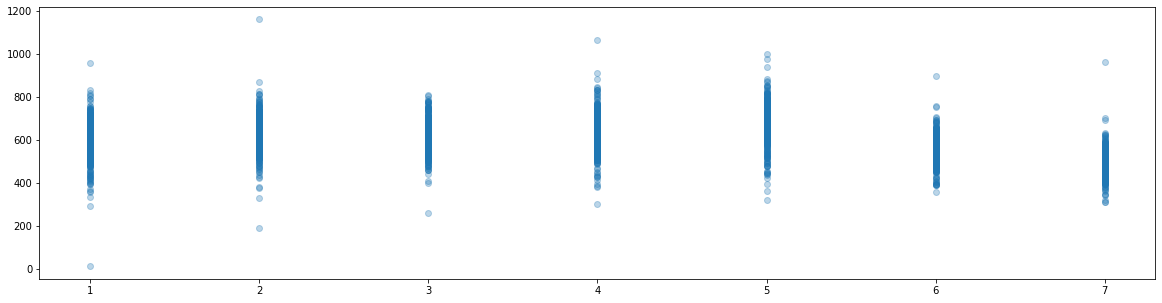

In [ ]:
plt.scatter(df.day, df.NUM_COLLISIONS, alpha=0.3) 
plt.show()

There will be some analysis and repetition of processes here while trying to find linear relationships, such as cleaning the data and testing different years.

The plot below is using the untouched dataframe **df**. You should change this to reflect any of the cleaning you have done.

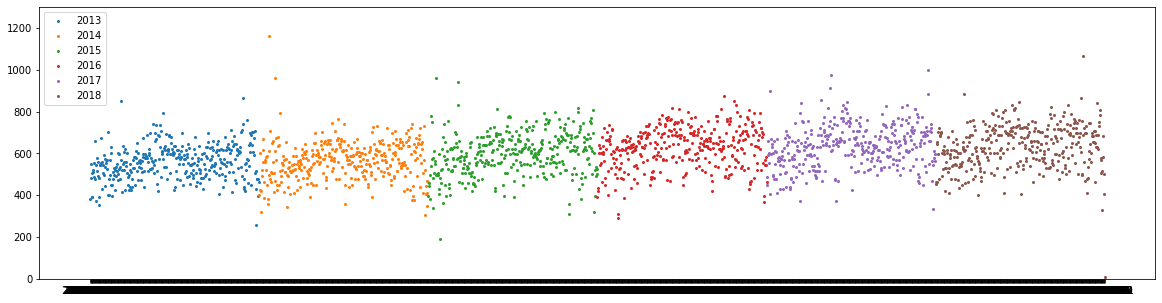

In [ ]:

groups = df.groupby('year') # We group by year as we want to create a legend and make the visualisation clearer using colour.
plt.ylim(0, 1300)
for name, group in groups:
    plt.plot(group.collision_date, group.NUM_COLLISIONS, marker='o', linestyle='', markersize=2, label=name)

plt.legend()

## Module 4: Regression models

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


# Module 5: Using the outcomes

In this section you want to use the test data to test what kind of money you will potentially make. 

Your company rents cars daily to people in New York City and is struggling in a saturated market. You have noted that you offer a flat rate damage waiver insurance package to all customers and that most customers chose not to take it. This package is something that has the potential to make the company lots of money if marketed properly.

At the moment you offer the package for a fee of 30 dollars per day, with only around 30% of all customers taking it. You rent on average 20,000 vehicles per day and therefore this package makes the company 180,000 dollars. The damage caused by collisions costs on average 500 dollars per collision with 8% of customers encountering a collision of some kind resulting in damage. The total costs from damage come to 800,000 dollars, which is covered by the customers' insurance, but around 10% of this is covered by the company due to fradulent behaviour or customers taking the waiver. This results in a profit of around 100,000 dollars per day for the sale of this package alone. 

This 30 dollars is based on an expected 1,200 collisions per day (based on the maximum).

The goal of this investigation is to accurately predict the number of expected collisions on a given day in order to reduce the price of the on-demand package and therefore give value to the customer. Surveys have shown that a competitive price would result in 80% of respondents taking the damage waiver insurance option – but the price must reflect the associated costs.

In [ ]:
df_2019_test_data = pd.read_csv('gdrive/My Drive/testdata2019.csv')

In [ ]:
df_2019_test_data = df_2019_test_data.sort_values(["year", "mo", "da"], ascending = (True, True, True))

In [ ]:
df_2019_test_data.head()

,day,year,mo,da,collision_date,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,NUM_COLLISIONS
0,2,2019,1,1,2019-01-01,50.5,43.2,1009.8,7.0,999.9,999.9,999.9,57.9,36.0,1.08,999.9,0,430
1,3,2019,1,2,2019-01-02,38.0,23.2,1024.2,10.0,999.9,999.9,999.9,57.9,35.1,0.06,999.9,0,502
2,4,2019,1,3,2019-01-03,41.1,29.4,1015.8,9.9,999.9,999.9,999.9,44.1,35.1,0.00,999.9,0,504
3,5,2019,1,4,2019-01-04,39.7,26.4,1014.8,9.9,999.9,999.9,999.9,46.0,35.1,0.00,999.9,0,598
4,6,2019,1,5,2019-01-05,44.2,41.0,1003.3,5.3,999.9,999.9,999.9,46.9,35.1,0.22,999.9,0,455
